# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Clustering




**Harvard University**<br/>
**Spring 2022**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas 


<hr style="height:2pt">

In [142]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<a id="instructions"></a>

<hr style="height:2pt">

### INSTRUCTIONS

- This is an individual homework - No collaboration is permitted

- To submit your assignment follow the instructions given in Canvas.

- Please **restart the kernel and run the entire notebook again before you submit.**

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code continues to work, restart the kernel and rerun your notebook periodically while working through this assignment. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use `.head(...)` when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate and report $R^2$", do not just output the value from a cell. Write a `print(...)` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- **Your plots MUST be clearly labeled and easy to read,** including clear labels for the $x$ and $y$ axes, a descriptive title ("MSE plot" is NOT a descriptive title; "Training and validation MSE at varying degree polynomial regression models" on the other hand is descriptive), a legend when appropriate, and clearly formatted text and graphics.

- **Your code may also be evaluated for efficiency and clarity.** As a result, correct output is not always sufficient for full credit.

<hr style="height:2pt">

In [143]:

import warnings
import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
from collections import namedtuple
from multiprocessing import cpu_count
from typing import Union, Iterable, Callable, Generator
from scipy.cluster.vq import kmeans2

try:
    import matplotlib.pyplot as plt

    MATPLOTLIB_FOUND = True
except ImportError:
    MATPLOTLIB_FOUND = False
    warnings.warn("matplotlib not installed; results plotting is disabled.")
try:
    from joblib import Parallel, delayed
except ImportError:
    Parallel, delayed = None, None
    warnings.warn(
        "joblib not installed, will be unavailable as a backend for parallel processing."
    )


GapCalcResult = namedtuple(
    "GapCalcResult", "gap_value n_clusters ref_dispersion_std sdk sk gap_star sk_star"
)


class OptimalK:
    """
    Obtain the optimal number of clusters a dataset should have using the gap statistic.
        Tibshirani, Walther, Hastie
        http://www.web.stanford.edu/~hastie/Papers/gap.pdf
    Example:
    >>> from sklearn.datasets.samples_generator import make_blobs
    >>> from gap_statistic import OptimalK
    >>> X, y = make_blobs(n_samples=int(1e5), n_features=2, centers=3, random_state=100)
    >>> optimalK = OptimalK(parallel_backend='joblib')
    >>> optimalK(X, cluster_array=[1,2,3,4,5])
    3
    """

    gap_df = None

    def __init__(
        self,
        n_jobs: int = -1,
        parallel_backend: str = "joblib",
        clusterer: Callable = None,
        clusterer_kwargs: dict = None,
        n_iter: int = 10,
    ) -> None:
        """
        Construct OptimalK to use n_jobs (multiprocessing using joblib, multiprocessing, or single core.
        if parallel_backend == 'rust' it will use all cores.
        :param n_jobs:
        :param parallel_backend:
        :param clusterer:
        :param clusterer_kwargs:
        :param n_iter int: only valid for 'rust' backend, iterations for Kmeans
        """
        if clusterer is not None and parallel_backend == "rust":
            raise ValueError(
                "Cannot use 'rust' backend with a user defined clustering function, only KMeans"
                " is supported on the rust implementation"
            )
        self.parallel_backend = (
            parallel_backend
            if parallel_backend in ["joblib", "multiprocessing", "rust"]
            else None
        )
        self.n_iter = n_iter
        self.n_jobs = n_jobs if 1 <= n_jobs <= cpu_count() else cpu_count()  # type: int
        self.n_jobs = 1 if parallel_backend is None else self.n_jobs
        self.clusterer = clusterer if clusterer is not None else kmeans2
        self.clusterer_kwargs = (
            clusterer_kwargs or dict()
            if clusterer is not None
            else dict(iter=10, minit="points")
        )

    def __call__(
        self,
        X: Union[pd.DataFrame, np.ndarray],
        n_refs: int = 3,
        cluster_array: Iterable[int] = (),
    ):
        """
        Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
        http://www.web.stanford.edu/~hastie/Papers/gap.pdf
        :param X - pandas dataframe or numpy array of data points of shape (n_samples, n_features)
        :param n_refs - int: Number of random reference data sets used as inertia reference to actual data.
        :param cluster_array - 1d iterable of integers; each representing n_clusters to try on the data.
        """

        # Convert the 1d array of n_clusters to try into an array
        # Raise error if values are less than 1 or larger than the unique sample in the set.
        cluster_array = np.array([x for x in cluster_array]).astype(int)
        if np.where(cluster_array < 1)[0].shape[0]:
            raise ValueError(
                "cluster_array contains values less than 1: {}".format(
                    cluster_array[np.where(cluster_array < 1)[0]]
                )
            )
        if cluster_array.shape[0] > X.shape[0]:
            raise ValueError(
                "The number of suggested clusters to try ({}) is larger than samples in dataset. ({})".format(
                    cluster_array.shape[0], X.shape[0]
                )
            )
        if not cluster_array.shape[0]:
            raise ValueError("The supplied cluster_array has no values.")

        # Array of resulting gaps.
        gap_df = pd.DataFrame({"n_clusters": [], "gap_value": []})

        # Define the compute engine; all methods take identical args and are generators.
        if self.parallel_backend == "joblib":
            engine = self._process_with_joblib
        elif self.parallel_backend == "multiprocessing":
            engine = self._process_with_multiprocessing
        elif self.parallel_backend == "rust":
            engine = self._process_with_rust
        else:
            engine = self._process_non_parallel

        # Calculate the gaps for each cluster count.
        for gap_calc_result in engine(X, n_refs, cluster_array):

            # Assign this loop's gap statistic to gaps
            gap_df = gap_df.append(
                {
                    "n_clusters": gap_calc_result.n_clusters,
                    "gap_value": gap_calc_result.gap_value,
                    "ref_dispersion_std": gap_calc_result.ref_dispersion_std,
                    "sdk": gap_calc_result.sdk,
                    "sk": gap_calc_result.sk,
                    "gap*": gap_calc_result.gap_star,
                    "sk*": gap_calc_result.sk_star,
                },
                ignore_index=True,
            )
            gap_df["gap_k+1"] = gap_df["gap_value"].shift(-1)
            gap_df["gap*_k+1"] = gap_df["gap*"].shift(-1)
            gap_df["sk+1"] = gap_df["sk"].shift(-1)
            gap_df["sk*+1"] = gap_df["sk*"].shift(-1)
            gap_df["diff"] = gap_df["gap_value"] - gap_df["gap_k+1"] + gap_df["sk+1"]
            gap_df["diff*"] = gap_df["gap*"] - gap_df["gap*_k+1"] + gap_df["sk*+1"]

        # drop auxilariy columns
        gap_df.drop(
            labels=["sdk", "gap_k+1", "gap*_k+1", "sk+1", "sk*+1"],
            axis=1,
            inplace=True,
            errors="ignore",
        )

        self.gap_df = gap_df.sort_values(by="n_clusters", ascending=True).reset_index(
            drop=True
        )
        self.n_clusters = int(
            self.gap_df.loc[np.argmax(self.gap_df.gap_value.values)].n_clusters
        )
        return self.n_clusters

    def plot_results(self):
        """
        Plots the results of the last run optimal K search procedure.
        Four plots are printed:
        (1) A plot of the Gap value - as defined in the original Tibshirani et
        al paper - versus n, the number of clusters.
        (2) A plot of diff versus n, the number of clusters, where diff =
        Gap(k) - Gap(k+1) + s_{k+1}. The original Tibshirani et al paper
        recommends choosing the smallest k such that this measure is positive.
        (3) A plot of the Gap* value - a variant of the Gap statistic suggested
        in "A comparison of Gap statistic definitions with and with-out
        logarithm function" [https://core.ac.uk/download/pdf/12172514.pdf],
        which simply removes the logarithm operation from the Gap calculation -
        versus n, the number of clusters.
        (4) A plot of the diff* value versus n, the number of clusters. diff*
        corresponds to the aforementioned diff value for the case of Gap*.
        """
        if not MATPLOTLIB_FOUND:
            print("matplotlib not installed; results plotting is disabled.")
            return
        if not hasattr(self, "gap_df") or self.gap_df is None:
            print("No results to print. OptimalK not called yet.")
            return

        # Gap values plot
        plt.plot(self.gap_df.n_clusters, self.gap_df.gap_value, linewidth=3)
        plt.scatter(
            self.gap_df[self.gap_df.n_clusters == self.n_clusters].n_clusters,
            self.gap_df[self.gap_df.n_clusters == self.n_clusters].gap_value,
            s=250,
            c="r",
        )
        plt.grid(True)
        plt.xlabel("Cluster Count")
        plt.ylabel("Gap Value")
        plt.title("Gap Values by Cluster Count")
        plt.show()

        # diff plot
        plt.plot(self.gap_df.n_clusters, self.gap_df["diff"], linewidth=3)
        plt.grid(True)
        plt.xlabel("Cluster Count")
        plt.ylabel("Diff Value")
        plt.title("Diff Values by Cluster Count")
        plt.show()

        # Gap* plot
        max_ix = self.gap_df[self.gap_df["gap*"] == self.gap_df["gap*"].max()].index[0]
        plt.plot(self.gap_df.n_clusters, self.gap_df["gap*"], linewidth=3)
        plt.scatter(
            self.gap_df.loc[max_ix]["n_clusters"],
            self.gap_df.loc[max_ix]["gap*"],
            s=250,
            c="r",
        )
        plt.grid(True)
        plt.xlabel("Cluster Count")
        plt.ylabel("Gap* Value")
        plt.title("Gap* Values by Cluster Count")
        plt.show()

        # diff* plot
        plt.plot(self.gap_df.n_clusters, self.gap_df["diff*"], linewidth=3)
        plt.grid(True)
        plt.xlabel("Cluster Count")
        plt.ylabel("Diff* Value")
        plt.title("Diff* Values by Cluster Count")
        plt.show()

    @staticmethod
    def _calculate_dispersion(
        X: Union[pd.DataFrame, np.ndarray], labels: np.ndarray, centroids: np.ndarray
    ) -> float:
        """
        Calculate the dispersion between actual points and their assigned centroids
        """
        disp = np.sum(
            np.sum(
                [np.abs(inst - centroids[label]) ** 2 for inst, label in zip(X, labels)]
            )
        )
        return disp

    def _calculate_gap(
        self, X: Union[pd.DataFrame, np.ndarray], n_refs: int, n_clusters: int
    ) -> GapCalcResult:
        """
        Calculate the gap value of the given data, n_refs, and number of clusters.
        Return the resutling gap value and n_clusters
        """
        # Holder for reference dispersion results
        ref_dispersions = np.zeros(n_refs)

        # Compute the range of each feature
        X = np.asarray(X)
        a, b = X.min(axis=0, keepdims=True), X.max(axis=0, keepdims=True)

        # For n_references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(n_refs):

            # Create new random reference set uniformly over the range of each feature
            random_data = np.random.random_sample(size=X.shape) * (b - a) + a

            # Fit to it, getting the centroids and labels, and add to accumulated reference dispersions array.
            centroids, labels = self.clusterer(
                random_data, n_clusters, **self.clusterer_kwargs
            )  # type: Tuple[np.ndarray, np.ndarray]
            dispersion = self._calculate_dispersion(
                X=random_data, labels=labels, centroids=centroids
            )
            ref_dispersions[i] = dispersion

        # Fit cluster to original data and create dispersion calc.
        centroids, labels = self.clusterer(
            X, n_clusters, **self.clusterer_kwargs
        )  # type: Tuple[np.ndarray, np.ndarray]
        dispersion = self._calculate_dispersion(X=X, labels=labels, centroids=centroids)

        # Calculate gap statistic
        ref_log_dispersion = np.mean(np.log(ref_dispersions))
        log_dispersion = np.log(dispersion)
        gap_value = ref_log_dispersion - log_dispersion
        # compute standard deviation
        sdk = np.sqrt(np.mean((np.log(ref_dispersions) - ref_log_dispersion) ** 2.0))
        sk = np.sqrt(1.0 + 1.0 / n_refs) * sdk

        # Calculate Gap* statistic
        # by "A comparison of Gap statistic definitions with and
        # with-out logarithm function"
        # https://core.ac.uk/download/pdf/12172514.pdf
        gap_star = np.mean(ref_dispersions) - dispersion
        sdk_star = np.sqrt(np.mean((ref_dispersions - dispersion) ** 2.0))
        sk_star = np.sqrt(1.0 + 1.0 / n_refs) * sdk_star

        return GapCalcResult(
            gap_value,
            int(n_clusters),
            ref_dispersions.std(),
            sdk,
            sk,
            gap_star,
            sk_star,
        )

    def _process_with_rust(
        self, X: Union[pd.DataFrame, np.ndarray], n_refs: int, cluster_array: np.ndarray
    ) -> Generator[GapCalcResult, None, None]:
        """
        Process gap stat using pure rust
        """
        try:
            import gapstat_rs
        except ImportError:
            warnings.warn(
                "Could not import 'gapstat_rs', perhaps gap-stat was not installed with this feature? "
                "`pip install gap-stat[rust]`"
            )
            raise

        X = X if isinstance(X, np.ndarray) else X.values
        X = X.astype(np.float64)

        cluster_array = np.array(cluster_array, dtype=np.int64)

        for (
            n_clusters,
            gap_value,
            ref_dispersion_std,
            sdk,
            sk,
            gap_star,
            sk_star,
        ) in gapstat_rs.optimal_k(X, cluster_array, self.n_iter, n_refs):
            yield GapCalcResult(
                gap_value, n_clusters, ref_dispersion_std, sdk, sk, gap_star, sk_star
            )

    def _process_with_joblib(
        self, X: Union[pd.DataFrame, np.ndarray], n_refs: int, cluster_array: np.ndarray
    ) -> Generator[GapCalcResult, None, None]:
        """
        Process calling of .calculate_gap() method using the joblib backend
        """
        if Parallel is None:
            raise EnvironmentError(
                "joblib is not installed; cannot use joblib as the parallel backend!"
            )

        with Parallel(n_jobs=self.n_jobs) as parallel:
            for gap_calc_result in parallel(
                delayed(self._calculate_gap)(X, n_refs, n_clusters)
                for n_clusters in cluster_array
            ):
                yield gap_calc_result

    def _process_with_multiprocessing(
        self, X: Union[pd.DataFrame, np.ndarray], n_refs: int, cluster_array: np.ndarray
    ) -> Generator[GapCalcResult, None, None]:
        """
        Process calling of .calculate_gap() method using the multiprocessing library
        """
        with ProcessPoolExecutor(max_workers=self.n_jobs) as executor:

            jobs = [
                executor.submit(self._calculate_gap, X, n_refs, n_clusters)
                for n_clusters in cluster_array
            ]
            for future in as_completed(jobs):
                yield future.result()

    def _process_non_parallel(
        self, X: Union[pd.DataFrame, np.ndarray], n_refs: int, cluster_array: np.ndarray
    ) -> Generator[GapCalcResult, None, None]:
        """
        Process calling of .calculate_gap() method using no parallel backend; simple for loop generator
        """
        for gap_calc_result in [
            self._calculate_gap(X, n_refs, n_clusters) for n_clusters in cluster_array
        ]:
            yield gap_calc_result

    def __str__(self):
        return 'OptimalK(n_jobs={}, parallel_backend="{}")'.format(
            self.n_jobs, self.parallel_backend
        )

    def __repr__(self):
        return self.__str__()

    def _repr_html_(self):
        return "<p>{}</p>".format(self.__str__())


### Import Libraries

In [144]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
#from gap_statistic import OptimalK


<hr style="height:2pt">

<a id="contents"></a>

# Notebook Contents

- [**Problem 1 [37.5 pts]: Clustering with k-means**](#part1)

- [**Problem 2 [37.5 pts]: Other Ks**](#part2)
  
- [**Problem 3 [25 pts]: Alternative Algorithms**](#part3)


<div class="theme">FMA: A Dataset For Music Analysis </div>


In this assignment, you will be working with data collected from The Free Music Archive (https://freemusicarchive.org/). The Free Music Archive is an online repository of original music from independent artists that can be freely downloaded. Each audio file (encoded as mp3) was then reduced into summary audio features using the librosa python package.


The dataset `fma.csv` contains 20,000 rows and 63 columns. Each row corresponds to the audio metadata for one music track. The metadata consists of nine audio features computed across time and summarized:

`1. Chroma, 7 attributes`

`2. Tonnetz, 7 attributes`

`3. Mel Frequency Cepstral Coefficient (MFCC), 7 attributes`

`4. Spectral centroid, 7 attributes`

`5. Spectral bandwidth, 7 attributes`

`6. Spectral contrast, 7 attributes`

`7. Spectral rolloff, 7 attributes`

`8. Root Mean Square energy, 7 attributes`

`9. Zero-crossing rate, 7 attributes`

For those interestend in more information about the FMA dataset please see the paper and GitHub repository (https://github.com/mdeff/fma)

<a id="part1"></a>

## <div class='exercise'>Problem 1: Clustering with k-means </div>

[Return to contents](#contents)

**1.1**  Start by reading the dataset into a Pandas DataFrame. The FMA website includes 16 different music genres, so we'll begin by assuming there are 16 clusters. First, normalize the dataset so that all features take on values in the range [0,1]. Next, run the k-means clustering algorithm with the `KMeans` class from `sklearn.cluster`, setting the number of clusters to 16, `n_init` to 42, and the random seed to 109. Finally, add the resulting cluster labels to your DataFrame as a new column called `Cluster16`.

**1.2**  Use the provided `plot_clusters` function to visualize the results of k-means on a random sample of 2,000 observations (the function will take the sample for you). Does 16 clusters seem to make sense?

**1.3** Plot the silhouette scores using the provided `silplot` function. Give it a 10% sample of the data to speed the visualization. How reasonable does the clustering seem based on this plot? How does it compare to the information in the plot above?

**1.4** Music from the FMA website consists of 4 different recording types: album, live recording, radio program, and single track. Repeat all of the above steps, but now assuming there are only 4 clusters. That is : 

- Run the k-means algorithm with 4 centroids instead of 16, assigning the generated labels to a new column in your DataFrame called `Cluster4` 

- Visualize the results for k-means. Does 4 clusters seem to make sense from this plot?

- Plot the silhouette scores on a 10% sample of the data. How reasonable does the clustering seem based on this plot?

**1.5** What does a comparison between your results using 16 clusters and 4 clusters suggest? Does this make sense in the context of what we know about the problem?

### Problem 1: Answers

[Return to contents](#contents)

<div class='exercise-r'>

**1.1**   Start by reading the dataset into a Pandas DataFrame. The FMA website includes 16 different music genres, so we'll begin by assuming there are 16 clusters. First, normalize the dataset so that all features take on values in the range [0,1]. Next, run the k-means clustering algorithm with the `KMeans` class from `sklearn.cluster`, setting the number of clusters to 16, `n_init` to 42, and the random seed to 109. Finally, add the resulting cluster labels to your DataFrame as a new column called `Cluster16`.



</div>

In [146]:
# your code here
df = pd.read_csv('data/fma.csv')
scaler = MinMaxScaler().fit_transform(df)
df_scaled = pd.DataFrame(scaler, columns = data.columns)

kmeans = KMeans(n_clusters=16, n_init=42, random_state=109).fit(df_scaled)
df_scaled['Cluster16'] = kmeans.labels_
df_scaled


,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,mfcc,mfcc.1,mfcc.2,...,tonnetz.5,tonnetz.6,zcr,zcr.1,zcr.2,zcr.3,zcr.4,zcr.5,zcr.6,Cluster16
0,0.000803,0.001274,0.003751,0.019572,0.007545,0.008177,0.021978,0.002642,0.004844,0.053210,...,0.023154,0.302169,0.002999,0.330831,0.071996,0.057766,0.037244,0.284238,0.095473,5
1,0.007796,0.003990,0.012031,0.021091,0.020338,0.062479,0.058665,0.018447,0.008065,0.164397,...,0.153133,0.149493,0.001399,0.419920,0.238846,0.239782,0.000000,0.233554,0.121275,4
2,0.002002,0.002178,0.010211,0.010494,0.009416,0.023729,0.021602,0.009648,0.014284,0.026623,...,0.029035,0.216879,0.001402,0.179179,0.058669,0.053406,0.031657,0.265141,0.051963,15
3,0.000281,0.000441,0.001640,0.065869,0.027857,0.001372,0.000196,0.002483,0.008402,0.086979,...,0.010561,0.251411,0.032215,0.480480,0.037384,0.030518,0.061453,0.390615,0.094820,12
4,0.001646,0.001170,0.002999,0.017684,0.010088,0.008841,0.013911,0.011206,0.005955,0.087399,...,0.031605,0.208361,0.000522,0.157157,0.089769,0.086104,0.031657,0.252612,0.065549,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.001261,0.001717,0.003657,0.023409,0.008121,0.025121,0.015090,0.002677,0.006308,0.034085,...,0.037636,0.216907,0.021009,0.692192,0.052851,0.047956,0.007449,0.298910,0.060639,3
19996,0.000901,0.001236,0.002035,0.012152,0.016760,0.018236,0.021823,0.002332,0.009690,0.080608,...,0.023304,0.158038,0.010831,0.461461,0.054767,0.038692,0.013035,0.329583,0.155328,2
19997,0.002472,0.002803,0.006212,0.030140,0.021021,0.015133,0.008717,0.002935,0.005539,0.068930,...,0.041680,0.203786,0.008887,0.462462,0.040961,0.020163,0.000000,0.322811,0.161863,2
19998,0.002976,0.004519,0.011415,0.037287,0.008029,0.016016,0.031024,0.002967,0.007160,0.207558,...,0.017430,0.192874,0.012978,0.339339,0.041154,0.029973,0.000000,0.331584,0.094360,1


<div class='exercise-r'>

**1.2**   Use the provided `plot_clusters` function to visualize the results of k-means on a random sample of 2,000 observations (the function will take the sample for you). Does 16 clusters seem to make sense?



</div>

In [147]:
def plot_clusters(full_data: pd.DataFrame, label_col: str):
    
    # seperate features only from cluster labels
    feature_columns = [colname for colname in list(full_data.columns) if 'Cluster' not in colname]
    features_only = full_data[feature_columns]

    # fit PCA to the whole data
    fitted_pca = PCA().fit(features_only)

    # take a sample of the whole data
    df_sample = features_only.sample(2000, random_state=109)

    # apply the PCA transform on the sample
    pca_sample = pd.DataFrame(fitted_pca.transform(df_sample), columns = ["PCA{}".format(i) for i in range(len(df_sample.columns.values))])
    pca_sample.index = df_sample.index
    
    # re-include a cluster label for the pca data
    pca_sample[label_col] = full_data.loc[pca_sample.index, label_col]
    
    plt.figure(figsize=(11,8.5))
    marker_types = [".", "v", "1", "^", "s", "p", "P", "3", "H", "<", "|", "_", "x", "*","d","X"]
    marker_colors = np.concatenate([np.array(plt.cm.tab10.colors),np.array(plt.cm.Pastel1.colors)])
    
    for i, (cluster_id, cur_df) in enumerate(pca_sample.groupby([label_col])):

        pca1_scores = cur_df.iloc[:,0]
        pca2_scores = cur_df.iloc[:,1]
        plt.scatter(pca1_scores, pca2_scores, label=cluster_id, c=marker_colors[i].reshape(1,-1), marker=marker_types[i])

    plt.xlabel("PC1 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[0],1)))
    plt.ylabel("PC2 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[1],1)))
    plt.legend()
    plt.show()
    return pca_sample

In [148]:
list_col = data.columns.tolist()
#list_col
feature_columns = [colname for colname in list(df_scaled.columns) if 'Cluster' not in colname]
features_only = df_scaled[feature_columns]
feature_columns==list_col



True

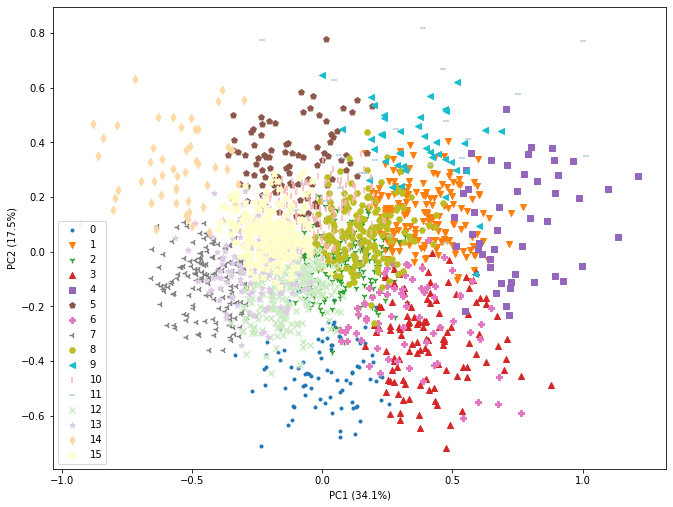

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,...,PCA54,PCA55,PCA56,PCA57,PCA58,PCA59,PCA60,PCA61,PCA62,Cluster16
11483,0.256649,0.154162,0.162050,-0.096632,-0.134206,0.048562,0.006920,0.011630,-0.027196,-0.068274,...,0.001805,0.002947,0.003744,0.002075,-0.000896,0.000405,-0.002782,0.000650,-0.000358,1
19209,-0.168378,0.179596,-0.068231,0.011810,-0.102788,-0.040944,0.080075,-0.037010,0.082736,0.012956,...,0.013359,0.005026,0.006927,0.003088,-0.005210,0.001316,-0.000951,-0.001058,0.000321,15
14635,0.112668,0.511660,0.035641,-0.105859,0.191182,0.082646,-0.139561,-0.036732,0.103945,-0.051519,...,0.001443,0.001458,-0.001132,0.001409,-0.000880,0.000951,-0.000378,-0.003594,-0.000113,5
18815,0.147064,0.045533,0.196348,-0.298335,-0.115120,-0.110735,-0.057102,-0.043947,0.368593,-0.094087,...,0.003454,-0.004026,-0.004639,0.002505,-0.000150,0.000430,-0.000780,0.001904,-0.000155,2
17947,0.435751,0.010503,0.019013,0.194529,-0.173906,0.086310,-0.150838,0.024491,-0.039001,-0.052339,...,0.001551,-0.004291,0.003641,-0.000191,0.009286,-0.001026,-0.001022,0.000003,-0.000344,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12160,-0.090730,0.271521,-0.335057,0.054372,-0.106262,-0.032035,0.038279,-0.005527,-0.085531,-0.058947,...,-0.000978,0.002032,-0.010871,-0.001563,-0.005596,-0.003202,0.002188,0.001731,0.000035,15
18978,-0.392638,-0.024655,-0.167939,-0.071129,-0.179075,0.015719,-0.014749,-0.039235,0.010952,0.040543,...,0.001273,-0.007380,0.004214,0.001024,0.000983,-0.001618,0.001611,0.001238,0.001071,7
4541,-0.007826,-0.159302,0.010511,-0.174178,0.128596,-0.069554,0.001570,-0.026702,0.009445,-0.030041,...,0.000764,0.000085,-0.003072,-0.001409,-0.000071,-0.000332,0.000474,-0.000099,-0.000096,12
285,-0.146981,-0.239423,0.055831,-0.166646,0.107362,-0.006100,-0.092138,0.021507,0.105080,0.011159,...,-0.002128,0.006688,0.005321,0.000213,0.000804,-0.000809,0.000003,0.000352,0.000213,12


In [149]:
# your code here

plot_clusters(df_scaled, label_col = 'Cluster16')

**No, in this case 16 clusters does not make sense because as seen in the graph they overlap a lot.**

<div class='exercise-r'>

**1.3**  Plot the silhouette scores using the provided `silplot` function. Give it a 10% sample of the data to speed the visualization. How reasonable does the clustering seem based on this plot? How does it compare to the information in the plot above?



</div>

In [150]:
df_sample = df_scaled.sample(2000, random_state=109)

df_sample_raw = df_sample.drop(columns=['Cluster16'])
df_sample_raw

,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,mfcc,mfcc.1,mfcc.2,...,tonnetz.4,tonnetz.5,tonnetz.6,zcr,zcr.1,zcr.2,zcr.3,zcr.4,zcr.5,zcr.6
11483,0.002533,0.001831,0.002096,0.014701,0.009613,0.014768,0.010582,0.003086,0.004787,0.039056,...,0.026688,0.045256,0.306912,0.008357,0.329830,0.040364,0.031063,0.000000,0.300069,0.072911
19209,0.001094,0.001426,0.004111,0.017826,0.012465,0.020076,0.022563,0.010365,0.007713,0.164288,...,0.057329,0.036362,0.310605,0.001006,0.132633,0.054741,0.052316,0.013035,0.256479,0.034920
14635,0.001042,0.001158,0.003398,0.019703,0.014857,0.037303,0.029868,0.002119,0.005352,0.082919,...,0.041127,0.018210,0.177719,0.002342,0.250751,0.091187,0.082834,0.044693,0.274596,0.088606
18815,0.001220,0.000981,0.002436,0.008253,0.003403,0.007424,0.011134,0.001497,0.004284,0.032150,...,0.036706,0.016798,0.267390,0.002185,0.216717,0.039690,0.022888,0.000000,0.280240,0.090977
17947,0.001292,0.000889,0.002219,0.011144,0.001458,0.002879,0.011946,0.021221,0.022054,0.083069,...,0.029571,0.030283,0.198208,0.005469,0.591592,0.104308,0.092098,0.000000,0.279501,0.100839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12160,0.000686,0.000877,0.007453,0.026933,0.004005,0.008369,0.074640,0.009802,0.002183,0.062355,...,0.021919,0.021390,0.224801,0.002342,0.146146,0.039415,0.037057,0.007449,0.262170,0.028576
18978,0.002524,0.003924,0.001980,0.035487,0.018121,0.165457,0.240062,0.009010,0.020975,0.058202,...,0.025438,0.019589,0.338258,0.001308,0.103604,0.050081,0.046866,0.000000,0.260764,0.033290
4541,0.001260,0.001052,0.003289,0.014239,0.007081,0.011933,0.026896,0.001212,0.003805,0.019569,...,0.038485,0.032231,0.255488,0.004171,0.441942,0.042856,0.023978,0.000000,0.287348,0.096436
285,0.001556,0.001666,0.004242,0.013184,0.007806,0.017735,0.030763,0.001339,0.005621,0.022925,...,0.030548,0.049245,0.268046,0.008704,0.430430,0.044627,0.031608,0.000000,0.312606,0.088967


In [153]:
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, cluster_labels, clusterer, pointlabels=None):
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(11,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example we 
    # will set a limit
    ax1.set_xlim([-0.2, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    # axes will be first 2 PCA components
    
    pca = PCA(n_components=2).fit(X)
    X_pca = pca.transform(X) 
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X_pca[:, 0]
    ys = X_pca[:, 1]    

    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters (transform to PCA space for plotting)
    centers = pca.transform(clusterer.cluster_centers_)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

For n_clusters = 16, the average silhouette_score is 0.09684948410166196.


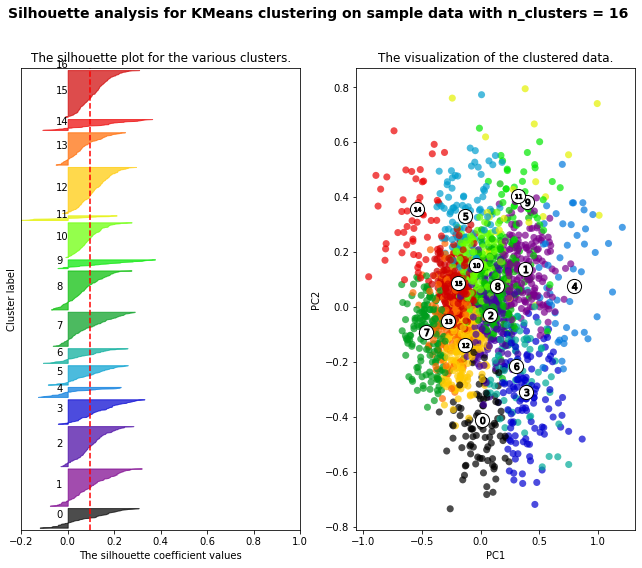

In [154]:
silplot(df_sample_raw, df_sample['Cluster16'], kmeans)

**Also from a silhouette perspective we can clearly see that 16 clusters is a bad choice because also here they mostly overlap and we get negative values for the silhouette coefficients.**

<div class='exercise-r'>

**1.4**  Music from the FMA website consists of 4 different recording types: album, live recording, radio program, and single track. Repeat all of the above steps, but now assuming there are only 4 clusters. That is : 

- Run the k-means algorithm with 4 centroids instead of 16, assigning the generated labels to a new column in your DataFrame called `Cluster4` 

- Visualize the results for k-means. Does 4 clusters seem to make sense from this plot?

- Plot the silhouette scores on a 10% sample of the data. How reasonable does the clustering seem based on this plot?



</div>

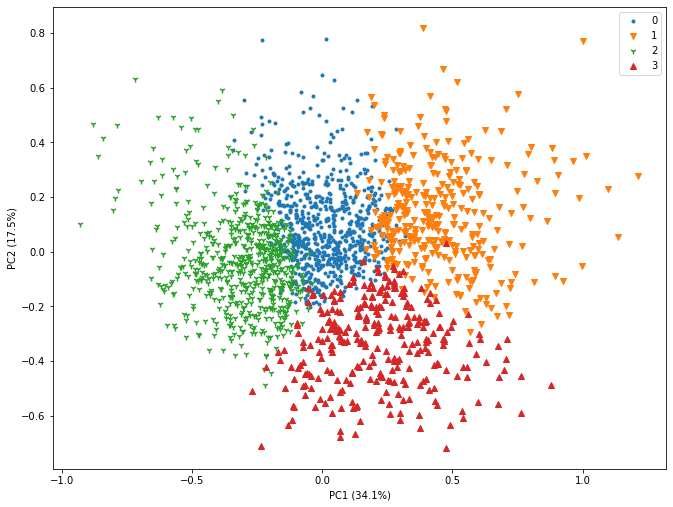

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,...,PCA54,PCA55,PCA56,PCA57,PCA58,PCA59,PCA60,PCA61,PCA62,Cluster4
11483,0.256649,0.154162,0.162050,-0.096632,-0.134206,0.048562,0.006920,0.011630,-0.027196,-0.068274,...,0.001805,0.002947,0.003744,0.002075,-0.000896,0.000405,-0.002782,0.000650,-0.000358,0
19209,-0.168378,0.179596,-0.068231,0.011810,-0.102788,-0.040944,0.080075,-0.037010,0.082736,0.012956,...,0.013359,0.005026,0.006927,0.003088,-0.005210,0.001316,-0.000951,-0.001058,0.000321,0
14635,0.112668,0.511660,0.035641,-0.105859,0.191182,0.082646,-0.139561,-0.036732,0.103945,-0.051519,...,0.001443,0.001458,-0.001132,0.001409,-0.000880,0.000951,-0.000378,-0.003594,-0.000113,0
18815,0.147064,0.045533,0.196348,-0.298335,-0.115120,-0.110735,-0.057102,-0.043947,0.368593,-0.094087,...,0.003454,-0.004026,-0.004639,0.002505,-0.000150,0.000430,-0.000780,0.001904,-0.000155,0
17947,0.435751,0.010503,0.019013,0.194529,-0.173906,0.086310,-0.150838,0.024491,-0.039001,-0.052339,...,0.001551,-0.004291,0.003641,-0.000191,0.009286,-0.001026,-0.001022,0.000003,-0.000344,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12160,-0.090730,0.271521,-0.335057,0.054372,-0.106262,-0.032035,0.038279,-0.005527,-0.085531,-0.058947,...,-0.000978,0.002032,-0.010871,-0.001563,-0.005596,-0.003202,0.002188,0.001731,0.000035,0
18978,-0.392638,-0.024655,-0.167939,-0.071129,-0.179075,0.015719,-0.014749,-0.039235,0.010952,0.040543,...,0.001273,-0.007380,0.004214,0.001024,0.000983,-0.001618,0.001611,0.001238,0.001071,2
4541,-0.007826,-0.159302,0.010511,-0.174178,0.128596,-0.069554,0.001570,-0.026702,0.009445,-0.030041,...,0.000764,0.000085,-0.003072,-0.001409,-0.000071,-0.000332,0.000474,-0.000099,-0.000096,0
285,-0.146981,-0.239423,0.055831,-0.166646,0.107362,-0.006100,-0.092138,0.021507,0.105080,0.011159,...,-0.002128,0.006688,0.005321,0.000213,0.000804,-0.000809,0.000003,0.000352,0.000213,2


In [155]:
# your code here

df_scaled = pd.DataFrame(df_scaled, columns = df.columns)
kmeans_4 = KMeans(n_clusters=4, n_init=42, random_state=109).fit(df_scaled)
df_scaled['Cluster4'] = kmeans_4.labels_
df_scaled
plot_clusters(df_scaled, label_col = 'Cluster4')

**Yes, 4 clusters seems reasonable for this data because we don't see overlaps.**

For n_clusters = 4, the average silhouette_score is 0.13406724736776665.


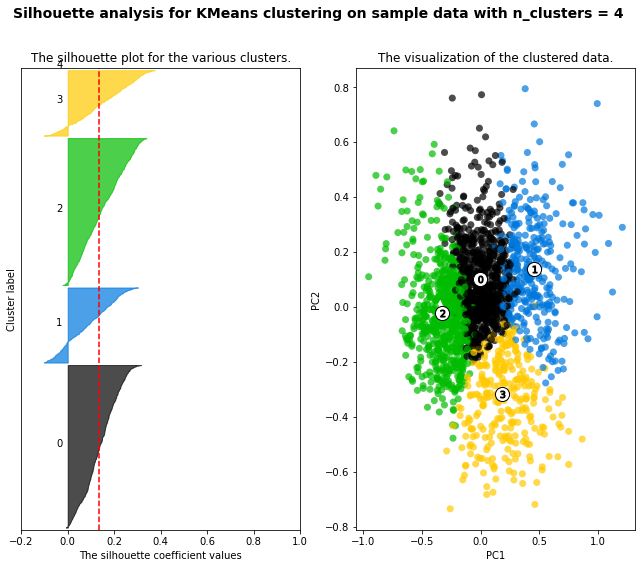

In [156]:
# your code here
df_sample = df_scaled.sample(2000, random_state=109)

df_sample_raw = df_sample.drop(columns=['Cluster4'])


silplot(df_sample_raw, df_sample['Cluster4'], kmeans_4)

**This plot seems more reasonable compared to the plot with 16 clusters. 4 clusters are better than 16 however still not ideal, because we can see the negative values of the silhouette plot on the left. We don't see as much overlapping among clusters as before however it is still present.**

<div class='exercise-r'>

**1.5**  What does a comparison between your results using 16 clusters and 4 clusters suggest? Does this make sense in the context of what we know about the problem?

</div>

**By comparing 16 and 4 we see that 16 is too specific and that it does not generalise enough. Music from the FMA website consists of 4 different recording types: album, live recording, radio program, and single track. Consequently, given this details of our dataset, 4 seems more approriate. Nonetheless, given the negative values from the silhouette plot this is still not the most efficient clustering and we need to explore the optimal number of clusters K with different and other clustering algorithms.**

<a id="part2"></a>

## <div class='exercise'>Problem 2: Other Ks </div>

[Return to contents](#contents)

In the previous problem, we examined the results of running k-means with 4 and 16 centroids on the fma data. In this problem, we will investigate a broader range of possible cluster sizes, with a broader range of metrics. 

**For all of these questions, you should work with a sample of 2,000 data points drawn with `pd.sample` and a random seed of 109.**

**2.1** Use the elbow method to evaluate the best choice of the number of clusters, plotting the total within-cluster variation against the number of clusters, for k-means clustering with $k \in \{1,2,...,20\}.$

**2.2** Use the average silhouette to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,...,20\}$. Plot the results. 

**2.3** Use the gap statistic to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,..,20\}$. Plot the results. 

**2.4** After analyzing the plots produced by all three of these measures, discuss the number of k-means clusters that you think is the best fit for this dataset. Defend your answer with evidence from the previous parts of this question, the three graphs produced here, and what you surmise about this dataset.

### Problem 2: Answers

[Return to contents](#contents)

<div class='exercise-r'>

**2.1**  Use the elbow method to evaluate the best choice of the number of clusters, plotting the total within-cluster variation against the number of clusters, for k-means clustering with $k \in \{1,2,...,20\}.$



</div>

In [157]:
# your code here
df_scaled = df_scaled.drop(columns=['Cluster4'])

In [158]:
df_scaled

,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,mfcc,mfcc.1,mfcc.2,...,tonnetz.4,tonnetz.5,tonnetz.6,zcr,zcr.1,zcr.2,zcr.3,zcr.4,zcr.5,zcr.6
0,0.000803,0.001274,0.003751,0.019572,0.007545,0.008177,0.021978,0.002642,0.004844,0.053210,...,0.038030,0.023154,0.302169,0.002999,0.330831,0.071996,0.057766,0.037244,0.284238,0.095473
1,0.007796,0.003990,0.012031,0.021091,0.020338,0.062479,0.058665,0.018447,0.008065,0.164397,...,0.031084,0.153133,0.149493,0.001399,0.419920,0.238846,0.239782,0.000000,0.233554,0.121275
2,0.002002,0.002178,0.010211,0.010494,0.009416,0.023729,0.021602,0.009648,0.014284,0.026623,...,0.026364,0.029035,0.216879,0.001402,0.179179,0.058669,0.053406,0.031657,0.265141,0.051963
3,0.000281,0.000441,0.001640,0.065869,0.027857,0.001372,0.000196,0.002483,0.008402,0.086979,...,0.026151,0.010561,0.251411,0.032215,0.480480,0.037384,0.030518,0.061453,0.390615,0.094820
4,0.001646,0.001170,0.002999,0.017684,0.010088,0.008841,0.013911,0.011206,0.005955,0.087399,...,0.022841,0.031605,0.208361,0.000522,0.157157,0.089769,0.086104,0.031657,0.252612,0.065549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.001261,0.001717,0.003657,0.023409,0.008121,0.025121,0.015090,0.002677,0.006308,0.034085,...,0.036566,0.037636,0.216907,0.021009,0.692192,0.052851,0.047956,0.007449,0.298910,0.060639
19996,0.000901,0.001236,0.002035,0.012152,0.016760,0.018236,0.021823,0.002332,0.009690,0.080608,...,0.030015,0.023304,0.158038,0.010831,0.461461,0.054767,0.038692,0.013035,0.329583,0.155328
19997,0.002472,0.002803,0.006212,0.030140,0.021021,0.015133,0.008717,0.002935,0.005539,0.068930,...,0.058430,0.041680,0.203786,0.008887,0.462462,0.040961,0.020163,0.000000,0.322811,0.161863
19998,0.002976,0.004519,0.011415,0.037287,0.008029,0.016016,0.031024,0.002967,0.007160,0.207558,...,0.021040,0.017430,0.192874,0.012978,0.339339,0.041154,0.029973,0.000000,0.331584,0.094360


In [159]:
df_sample = df_scaled.sample(2000, random_state=109)

wss = []
for i in range(1,21):
    fitx = KMeans(n_clusters=i, init='random', n_init=42, random_state=109).fit(df_sample)
    wss.append(fitx.inertia_)

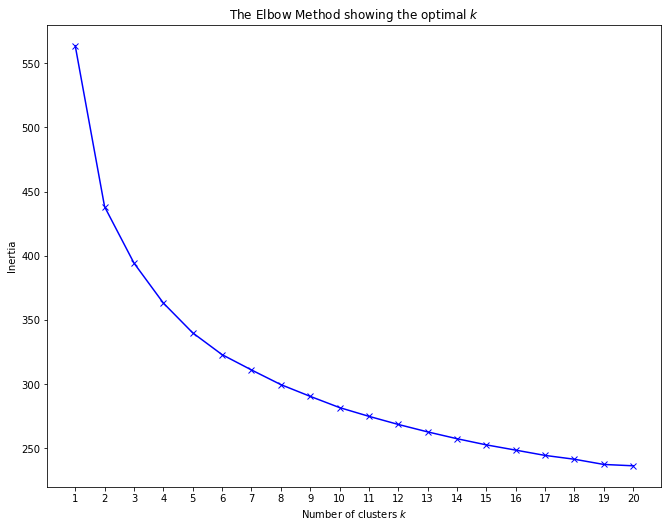

In [160]:
plt.figure(figsize=(11,8.5))
plt.plot(range(1,21), wss, 'bx-')
plt.xlabel('Number of clusters $k$')
plt.xticks(range(1,21))
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal $k$')
plt.show()

In [161]:
df_sample

,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,mfcc,mfcc.1,mfcc.2,...,tonnetz.4,tonnetz.5,tonnetz.6,zcr,zcr.1,zcr.2,zcr.3,zcr.4,zcr.5,zcr.6
11483,0.002533,0.001831,0.002096,0.014701,0.009613,0.014768,0.010582,0.003086,0.004787,0.039056,...,0.026688,0.045256,0.306912,0.008357,0.329830,0.040364,0.031063,0.000000,0.300069,0.072911
19209,0.001094,0.001426,0.004111,0.017826,0.012465,0.020076,0.022563,0.010365,0.007713,0.164288,...,0.057329,0.036362,0.310605,0.001006,0.132633,0.054741,0.052316,0.013035,0.256479,0.034920
14635,0.001042,0.001158,0.003398,0.019703,0.014857,0.037303,0.029868,0.002119,0.005352,0.082919,...,0.041127,0.018210,0.177719,0.002342,0.250751,0.091187,0.082834,0.044693,0.274596,0.088606
18815,0.001220,0.000981,0.002436,0.008253,0.003403,0.007424,0.011134,0.001497,0.004284,0.032150,...,0.036706,0.016798,0.267390,0.002185,0.216717,0.039690,0.022888,0.000000,0.280240,0.090977
17947,0.001292,0.000889,0.002219,0.011144,0.001458,0.002879,0.011946,0.021221,0.022054,0.083069,...,0.029571,0.030283,0.198208,0.005469,0.591592,0.104308,0.092098,0.000000,0.279501,0.100839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12160,0.000686,0.000877,0.007453,0.026933,0.004005,0.008369,0.074640,0.009802,0.002183,0.062355,...,0.021919,0.021390,0.224801,0.002342,0.146146,0.039415,0.037057,0.007449,0.262170,0.028576
18978,0.002524,0.003924,0.001980,0.035487,0.018121,0.165457,0.240062,0.009010,0.020975,0.058202,...,0.025438,0.019589,0.338258,0.001308,0.103604,0.050081,0.046866,0.000000,0.260764,0.033290
4541,0.001260,0.001052,0.003289,0.014239,0.007081,0.011933,0.026896,0.001212,0.003805,0.019569,...,0.038485,0.032231,0.255488,0.004171,0.441942,0.042856,0.023978,0.000000,0.287348,0.096436
285,0.001556,0.001666,0.004242,0.013184,0.007806,0.017735,0.030763,0.001339,0.005621,0.022925,...,0.030548,0.049245,0.268046,0.008704,0.430430,0.044627,0.031608,0.000000,0.312606,0.088967


**The first kink is at 2 - hence, it seems that according to the elbow plot the ideal number of clusters is 2.**

<div class='exercise-r'>

**2.2**  Use the average silhouette to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,...,20\}$. Plot the results. 



</div>

In [162]:
# your code here
scores = [0]
for i in range(2,21):
    fitx = KMeans(n_clusters=i, init='random', n_init=42, random_state=109).fit(df_sample)
    score = silhouette_score(df_sample, fitx.labels_)
    scores.append(score)
    

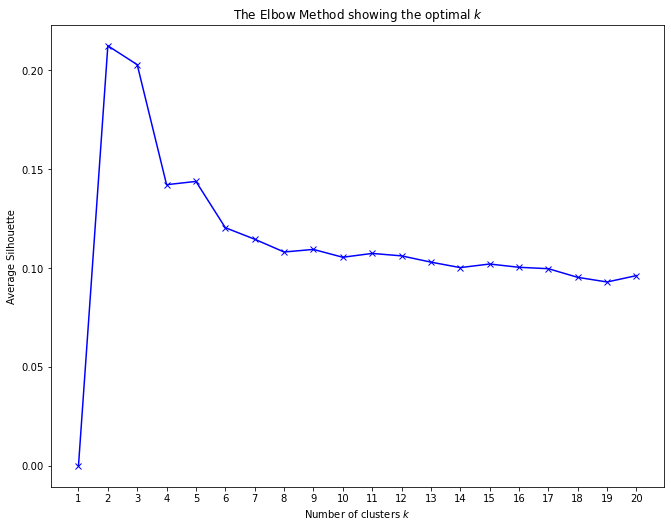

In [163]:
plt.figure(figsize=(11,8.5))
plt.plot(range(1,21), np.array(scores), 'bx-')
plt.xlabel('Number of clusters $k$')
plt.xticks(range(1,21))

plt.ylabel('Average Silhouette')
plt.title('The Elbow Method showing the optimal $k$')
plt.show()

**Also from this graph, we can see that the average silhouette the highest value is from 2 clusters. Consequently, 2 clusters seems to be an ideal number of clusters for this dataset.**

<div class='exercise-r'>

**2.3**  Use the gap statistic to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,..,20\}$. Plot the results. 



</div>

In [178]:
# your code here
gs_obj = OptimalK()

n_clusters = gs_obj(df_sample, n_refs=500, cluster_array=np.arange(1, 21))
print('Optimal number of clusters: ', n_clusters)

Optimal number of clusters:  20


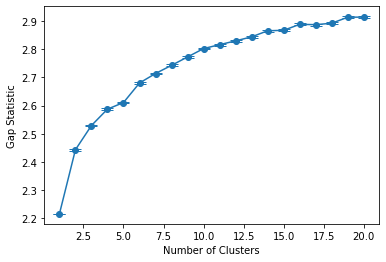

In [179]:
def display_gapstat_with_errbars(gap_df):
    gaps = gap_df["gap_value"].values
    diffs = gap_df["diff"]
    
    err_bars = np.zeros(len(gap_df))
    err_bars[1:] = diffs[:-1] - gaps[:-1] + gaps[1:]

    plt.scatter(gap_df["n_clusters"], gap_df["gap_value"])
    plt.errorbar(gap_df["n_clusters"], gap_df["gap_value"], yerr=err_bars, capsize=6)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Gap Statistic")
    plt.show()
    
display_gapstat_with_errbars(gs_obj.gap_df)

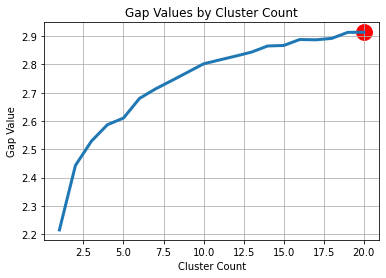

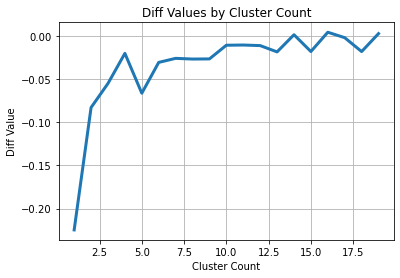

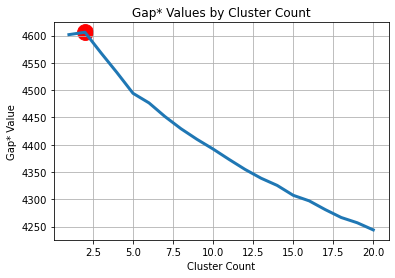

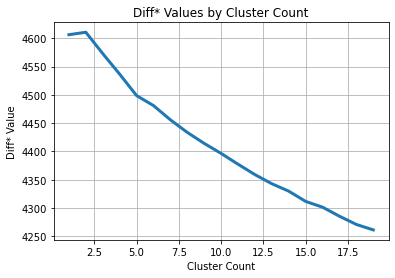

In [180]:
gs_obj.plot_results()

**As we can see, the highest value of gap statistic is reached at 20 clusters.**

<div class='exercise-r'>

**2.4**  After analyzing the plots produced by all three of these measures, discuss the number of k-means clusters that you think is the best fit for this dataset. Defend your answer with evidence from the previous parts of this question, the three graphs produced here, and what you surmise about this dataset.

</div>

**By comparing 20, 16 , 4 and 2 possible number for cluster amounts, the number of cluster that seems most plausible is 4 because of the structure of our data (different recordint types, live recording, album, radio program, or single track) and 2.**

<a id="part3"></a>

## <div class='exercise'>Problem 3: Alternative Algorithms </div>

[Return to contents](#contents)

**3.1** Create a knee plot to determine an optimal epsilon then run DBSCAN on the data. This process should result in one very large cluster, and at most 1-2 other small clusters, ignoring outliers. What about the data might lead to this result of DBSCAN?\
*Note*: Do not use a sample of the data. This may take a few minutes to run.

**3.2** Hierarchical clustering will be our next approach. Run agglomerative clustering (using Ward's method), and plot the result using a dendrogram. Interpret the results, and describe the cluster size(s) the plot suggests. What level of aggregation is suggested by the silhoutte score?

**3.3** Overall, what do you conclude about the number and kind of clusters in this data set?

### Problem 3: Answers

[Return to contents](#contents)

<div class='exercise-r'>

**3.1**  Create a knee plot to determine an optimal epsilon then run DBSCAN on the data. This process should result in one very large cluster, and at most 1-2 other small clusters, ignoring outliers. What about the data might lead to this result of DBSCAN?\
*Note*: Do not use a sample of the data. This may take a few minutes to run.



</div>

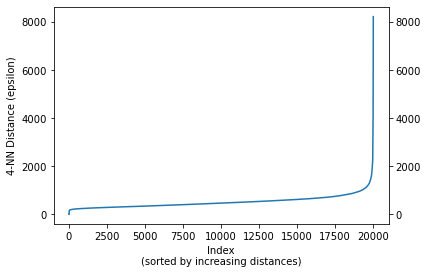

In [181]:
# your code here

df_scaled

from sklearn.neighbors import NearestNeighbors

def plot_epsilon(df_scaled, min_samples):

    fitted_neigbors = NearestNeighbors(n_neighbors=min_samples).fit(df)
    distances, indices = fitted_neigbors.kneighbors(df)
    
    dist_to_nth_nearest_neighbor = distances[:,-1]
    plt.plot(np.sort(dist_to_nth_nearest_neighbor))
    plt.xlabel("Index\n(sorted by increasing distances)")
    plt.ylabel("{}-NN Distance (epsilon)".format(min_samples-1))
    plt.tick_params(right=True, labelright=True)
    
plot_epsilon(df_scaled, 5)

<div class='exercise-r'>

**3.2**  Hierarchical clustering will be our next approach. Run agglomerative clustering (using Ward's method), and plot the result using a dendrogram. Interpret the results, and describe the cluster size(s) the plot suggests. What level of aggregation is suggested by the silhoutte score?



</div>

In [186]:
df_scaled

,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,mfcc,mfcc.1,mfcc.2,...,tonnetz.4,tonnetz.5,tonnetz.6,zcr,zcr.1,zcr.2,zcr.3,zcr.4,zcr.5,zcr.6
0,0.000803,0.001274,0.003751,0.019572,0.007545,0.008177,0.021978,0.002642,0.004844,0.053210,...,0.038030,0.023154,0.302169,0.002999,0.330831,0.071996,0.057766,0.037244,0.284238,0.095473
1,0.007796,0.003990,0.012031,0.021091,0.020338,0.062479,0.058665,0.018447,0.008065,0.164397,...,0.031084,0.153133,0.149493,0.001399,0.419920,0.238846,0.239782,0.000000,0.233554,0.121275
2,0.002002,0.002178,0.010211,0.010494,0.009416,0.023729,0.021602,0.009648,0.014284,0.026623,...,0.026364,0.029035,0.216879,0.001402,0.179179,0.058669,0.053406,0.031657,0.265141,0.051963
3,0.000281,0.000441,0.001640,0.065869,0.027857,0.001372,0.000196,0.002483,0.008402,0.086979,...,0.026151,0.010561,0.251411,0.032215,0.480480,0.037384,0.030518,0.061453,0.390615,0.094820
4,0.001646,0.001170,0.002999,0.017684,0.010088,0.008841,0.013911,0.011206,0.005955,0.087399,...,0.022841,0.031605,0.208361,0.000522,0.157157,0.089769,0.086104,0.031657,0.252612,0.065549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.001261,0.001717,0.003657,0.023409,0.008121,0.025121,0.015090,0.002677,0.006308,0.034085,...,0.036566,0.037636,0.216907,0.021009,0.692192,0.052851,0.047956,0.007449,0.298910,0.060639
19996,0.000901,0.001236,0.002035,0.012152,0.016760,0.018236,0.021823,0.002332,0.009690,0.080608,...,0.030015,0.023304,0.158038,0.010831,0.461461,0.054767,0.038692,0.013035,0.329583,0.155328
19997,0.002472,0.002803,0.006212,0.030140,0.021021,0.015133,0.008717,0.002935,0.005539,0.068930,...,0.058430,0.041680,0.203786,0.008887,0.462462,0.040961,0.020163,0.000000,0.322811,0.161863
19998,0.002976,0.004519,0.011415,0.037287,0.008029,0.016016,0.031024,0.002967,0.007160,0.207558,...,0.021040,0.017430,0.192874,0.012978,0.339339,0.041154,0.029973,0.000000,0.331584,0.094360


In [189]:
# your code here

df_sample
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist

plt.figure(figsize=(11,8.5))
dist_mat = pdist(df_scaled, metric="euclidean")
ward_data = hac.ward(dist_mat)

<Figure size 792x612 with 0 Axes>

In [190]:
# hac.dendrogram(ward_data);
# plt.title("Dendogram showing the clusters for the whole data")
# plt.ylabel("Distances between clusters")
# plt.xlabel("Observations")
# plt.show()

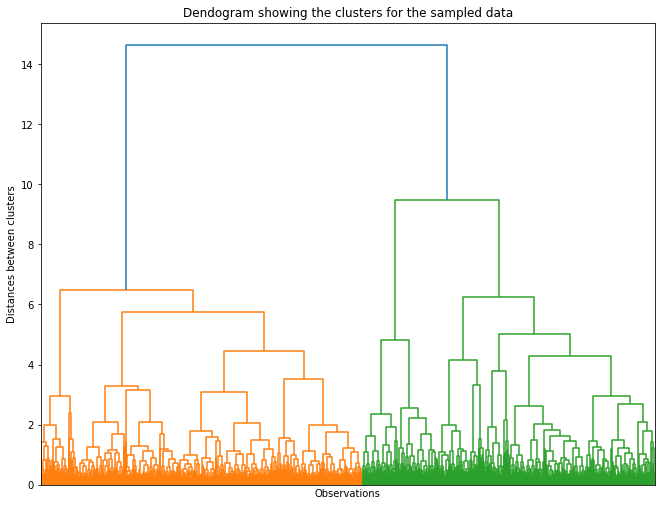

In [191]:
# your code here

df_sample
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist

plt.figure(figsize=(11,8.5))
dist_mat = pdist(df_sample, metric="euclidean")
ward_data = hac.ward(dist_mat)

hac.dendrogram(ward_data, no_labels = True);
plt.title("Dendogram showing the clusters for the sampled data")
plt.ylabel("Distances between clusters")
plt.xlabel("Observations")
plt.show()

**As seen from the colours, the dendogram suggests 2 clusters. The height of that split tells us how much the distance between clusters goes up according to the wards calculaiton of distance.**

In [192]:
ward_data

array([[1.42000000e+03, 1.82200000e+03, 7.61751552e-02, 2.00000000e+00],
       [7.05000000e+02, 1.60500000e+03, 1.19653291e-01, 2.00000000e+00],
       [4.86000000e+02, 8.58000000e+02, 1.21783530e-01, 2.00000000e+00],
       ...,
       [3.98100000e+03, 3.99400000e+03, 6.47842098e+00, 1.04900000e+03],
       [3.99200000e+03, 3.99500000e+03, 9.49202870e+00, 9.51000000e+02],
       [3.99600000e+03, 3.99700000e+03, 1.46429163e+01, 2.00000000e+03]])

In [193]:
# your code here
score_list = []
for i in range(1,15):
    cluster_numn = fcluster(ward_data, i, criterion='distance')
    score = silhouette_score(df_sample, cluster_numn)
    score_list.append(score)
    
    

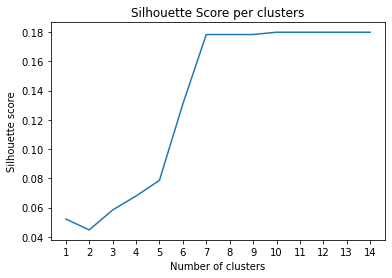

In [194]:
plt.plot(range(1, 15), score_list)
plt.title("Silhouette Score per clusters")
plt.xlabel("Number of clusters")
plt.xticks(range(1,15))
plt.ylabel("Silhouette score")
plt.show()


    
    

**The silhoutte suggests 7 clusters.**

<div class='exercise-r'>

**3.3**  Overall, what do you conclude about the number and kind of clusters in this data set?

</div>

**We can conclde that there is no ideal number of clusters  - as we see, every method suggests a different number. First we saw 20 suggested, then 2, and lastly 7. We suggest to discuss with the domain-expert of the field the dagaset comes from to best puick the ideal numebr of clusters.**

**As we have seen, 4 might make more sense for the structure of our data. However, several clustering algorithm metrics suggested 2 to be the ideal number of clusters.**